# Use deep learning to detect Surface-to-Air Missile (SAM) sites

In [1]:
from fastai.imports import *
from torchvision.models import resnet34
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

## Set up training and validation directories

The data is split in *train* and *valid* directories. Each dir has subdirectories for each class we wish to recognize (in this case, 'sam' and 'ground').

In [2]:
sz = 224
PATH = "data/sam/"

!ls {PATH}

models	test.jpg  tmp  train  valid


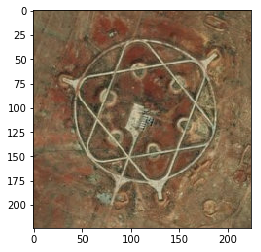

In [3]:
files = !ls {PATH}valid/sam | head
img = plt.imread(f'{PATH}valid/sam/{files[1]}')
plt.imshow(img);

## Using Pre-trained model

Using [ResNet34](https://github.com/KaimingHe/deep-residual-networks) that won the 2015 ImageNet competition. ResNet was trained on ImageNet (1.2 million images and 1000 classes).

In [28]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(resnet34, sz))

model = ConvLearner.pretrained(resnet34, data, precompute=True)
model.fit(0.01, 6)

[0.      0.22342 0.11402 0.96249]                          
[1.      0.11631 0.10015 0.9656 ]                          
[2.      0.08506 0.09877 0.9656 ]                           
[3.      0.07314 0.1008  0.96448]                           
[4.      0.05771 0.09685 0.9656 ]                           
[5.      0.05107 0.09235 0.9687 ]                           



We achieve a high accuracy using this pretrained model using transfer learning.

### Analyze results

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [16]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = model.predict()

preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:, 1])

In [17]:
from IPython.display import HTML

def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            p = titles[i]
            pct = int(p*100)
            klass = 'SAM site' if p > 0.5 else 'Ground'
            sp.set_title(klass, fontsize=16, y=-0.15)
        plt.imshow(ims[i])

def load_img_id(ds, idx): 
    return np.array(PIL.Image.open(PATH + ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    display(HTML('<center><h2>{}</h2></center>'.format(title)))
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

# from here we know that 'ground' is label 0 and 'sam' is label 1.
data.classes

['ground', 'sam']

### Some examples of correct and incorrect classifications:

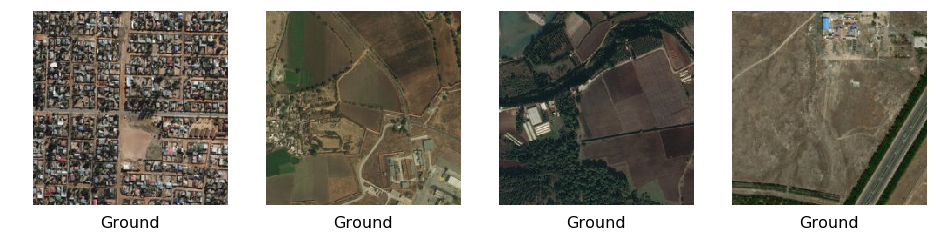

In [29]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

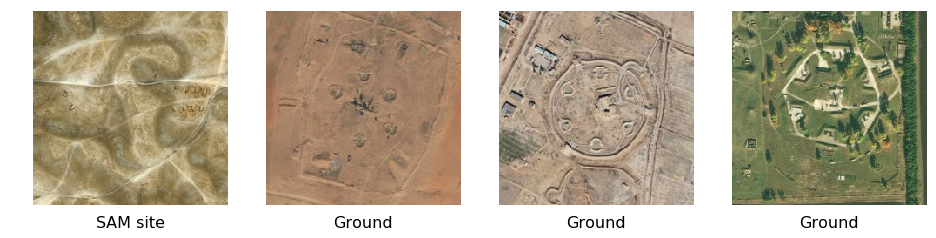

In [30]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

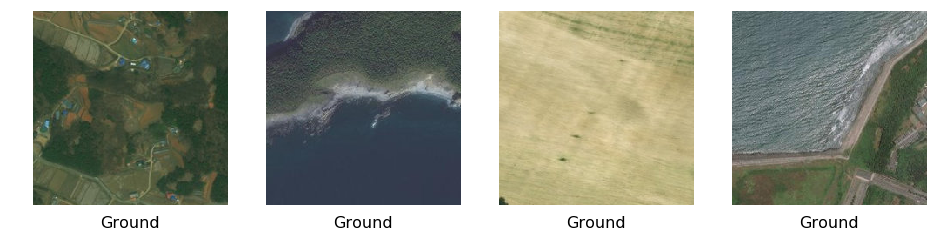

In [31]:
plot_val_with_title(most_by_correct(0, True), "Most correct ground")

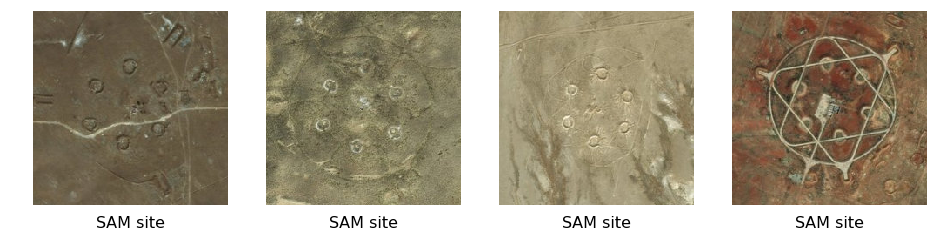

In [32]:
plot_val_with_title(most_by_correct(1, True), "Most correct SAM sites")

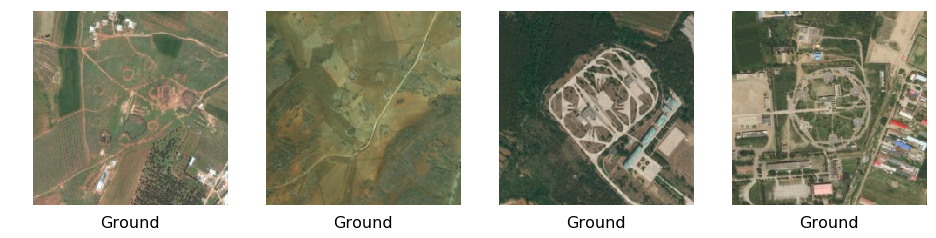

In [33]:
plot_val_with_title(most_by_correct(1, False), "SAM sites missed by model")

# Improve the model

## Choosing an optimum learning rate
The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss starts decreasing. We can plot the learning rate across batches to see what this looks like.

[   0.         1.68595 7167.05029    0.11384]              



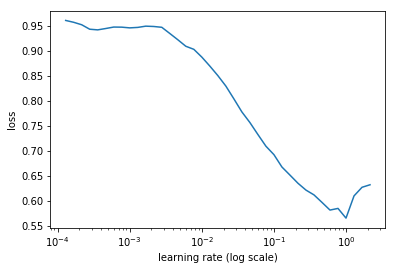

In [12]:
arch = resnet34
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf = learn.lr_find()
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

## Data augmentation

Randomly flip, zoom and rotate the images to avoid overfitting and work with small training set.

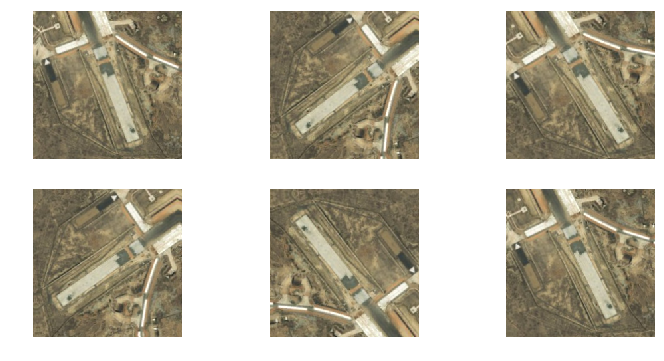

In [34]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

Use the optimum learning rate with data augmentation.

In [14]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 1)

[0.      0.22252 0.11294 0.95939]                          



By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [15]:
learn.precompute = False
learn.fit(1e-2, 3, cycle_len=1)

[0.      0.09275 0.11539 0.95827]                           
[1.      0.08568 0.09893 0.9656 ]                           
[2.      0.07877 0.10564 0.95827]                           



### Use Stochastic Gradient Descent with restarts

Here we're using a technique called *stochastic gradient descent with restarts (SGDR)*, a variant of *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, call `unfreeze()`.

In [ ]:
learn.unfreeze()
lr = np.array([1e-4, 1e-3, 1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

[0.      0.09211 0.10448 0.962  ]                           
[1.      0.07725 0.09003 0.97156]                           
[2.      0.07008 0.08475 0.97156]                           
[3.      0.05776 0.06855 0.97579]                           
 85%|████████▌ | 46/54 [00:37<00:06,  1.24it/s, loss=0.0549]

### Save the model

The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [17]:
learn.save('sam_finetuned_227')

### Check accuracy using test time augmentation

In [23]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)

accuracy(probs, y)

0.9976608187134502

We generally see about a 10-20% reduction in error when using test time augmentation.

## Analyzing results

### Confusion matrix 

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

[[823   0]
 [  2  30]]


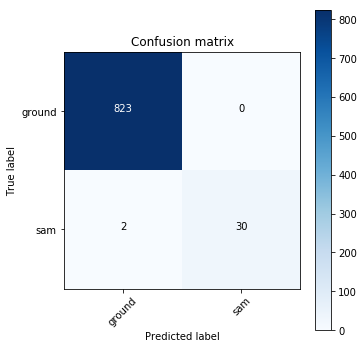

In [24]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

cm = confusion_matrix(y, preds)
mpl.rcParams['figure.figsize'] = (5,5)
plot_confusion_matrix(cm, data.classes)

### Reviewing final model

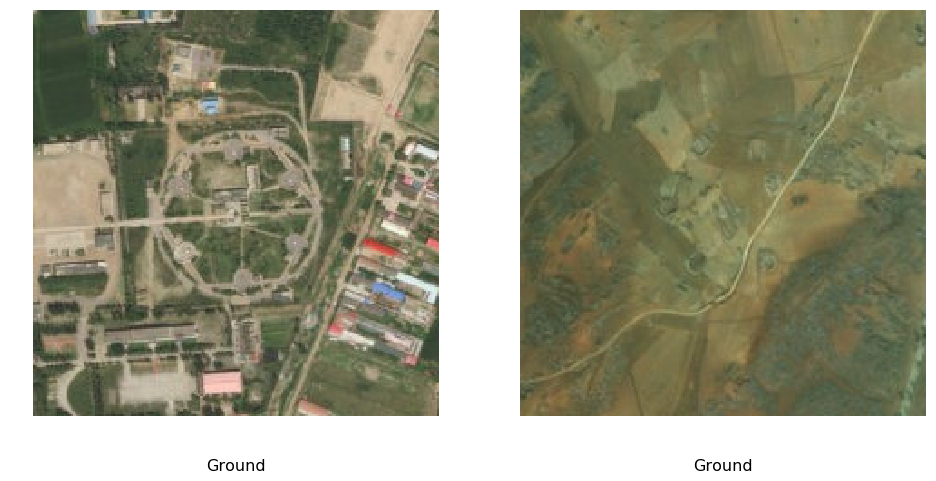

In [25]:
plot_val_with_title(most_by_correct(0, False), "Incorrect predictions")

### Test model in new area

In [10]:
# arch = resnet34

# trn_tfms, val_tfrms = tfms_from_model(arch, sz)


def predict_img(npimg):
    return 0
#     im = val_tfrms(npimg)
#     log_preds = learn.predict_array(im[None])
#     probs = np.exp(log_preds[:,1]) 
#     return probs[0]

def sliding_window_detector():
    ext = {'type': 'extent', 'xmin': 8154355., 'ymin': 3966803., 'xmax': 8159142., 'ymax': 3968713., 'spatialReference': {'wkid': 102100, 'latestWkid': 3857}}
    # m.extent
    x = (ext['xmin'] + ext['xmax']) / 2
    y = (ext['ymin'] + ext['ymax']) / 2
    extw = ext['xmax'] - ext['xmin']
    exth = ext['ymax'] - ext['ymin']

    ext1 = (x-900, y-900, x+900, y+900)
    lyr.export_map(ext1, 102100, '672,672', f='image', format='jpg', save_folder='.',
                   save_file='test.jpg')   
    img = 0 #open_image('./test.jpg')

    H, W, h, w = 672, 672, 224, 224

    windows, sizes = [], []
    for row in range(int(4*(H/h) - 3)):
        for col in range(int(4*(W/w) - 3)):
            y1 = int(row * h / 4)
            x1 = int(col * w / 4)
            sizes.append((x1, y1, w, h))
            window = [0] #img[y1:y1+w, x1:x1+w, :]
            windows.append(window)
    drawn = False
    positive, predictions = [], []
    for i in range(len(windows)):
        try:
            prediction = predict_img(windows[i])
            predictions.append(prediction)
        except:
            prediction = 0
        
        if prediction > 0.5:
            positive.append(i)
            x1, y1, x2, y2 = sizes[i]
            x = (x1+x2)/2
            y = (y1+y2)/2
            cx = ext['xmin'] + (x+112)*extw/W
            cy = ext['ymin'] + (y+112)*exth/H
            f = 300
            polyline = {
                "paths" : [ 
                 [ [cx-f, cy-f], [cx+f, cy-f], [cx+f, cy+f], [cx-f, cy+f], [cx-f, cy-f]]
                ],
                "spatialReference" : {'latestWkid': 3857, 'wkid': 102100}
            }
            m.draw(polyline, symbol={
                "color": [255, 255, 0, 255],
                "width": 3,
                "type": "esriSLS",
                "style": "esriSLSSolid"
            })

            m.draw({'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
                     'type': 'point',
                     'x': cx,
                     'y': cy}, symbol={"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/PeoplePlaces/Capital1.png","contentType":"image/png","width":24,"height":24})

            drawn = True 
            if drawn: break

### Detect SAM sites

In [16]:
from arcgis import GIS
from arcgis.mapping import MapImageLayer

gis = GIS()

imagery = gis.content.search('title:World Imagery', 'Map Service', outside_org=True)[0]
lyr = MapImageLayer.fromitem(imagery)

m = gis.map((33.5436, 73.253537), zoomlevel=14)
m.basemap ='satellite'
display(m)

MapView(basemaps=['dark-gray', 'dark-gray-vector', 'gray', 'gray-vector', 'hybrid', 'national-geographic', 'oceans', 'osm', 'satellite', 'streets', 'streets-navigation-vector', 'streets-night-vector', 'streets-relief-vector', 'streets-vector', 'terrain', 'topo', 'topo-vector'], center=[33.5436, 73.253537], zoom=14)

In [17]:
sliding_window_detector()

## Review: steps to train this object detector

1. Used a public **Feature Layer** as the source of labeled data.
2. Used the Python API to extract image chips from **Esri World Imagery**.
3. Fed input into a **pretrained deep learning model** using fastai.
4. **Fine tuned** the model on satellite imagery, and
5. Tested the results using **sliding windows**.
6. Displayed the results using the ArcGIS **map widget**.

### Next Steps
The model is now trained and can be deployed using **Python Raster Functions**, to be applied across a large area using distributed raster analytics.

To learn more about these techniques, refer to the following resources:
* https://developers.arcgis.com/python/guide/
* https://github.com/fastai/fastai/blob/master/courses/dl1/